# Spleen Segmentation Exercise

In this exercise, we will implement Spleen segmentation using the Medical Decathalon dataset. We'll follow these general steps:  

1. Transforms for dictionary format data.
2. Load Nifti image with metadata.
3. Add channel dim to the data if no channel dimension.
4. Scale medical image intensity with expected range.
5. Crop out a batch of balanced images based on positive / negative label ratio.
6. Cache IO and transforms to accelerate training and validation.
7. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
8. Sliding window inference method.
9. Deterministic training for reproducibility.

Optionally replace the training loop with the Ignite-derived engine classes.

First, we install and import MONAI plug other dependencies.

In [ ]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [1]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

MONAI version: 0.6.0
Numpy version: 1.20.3
Pytorch version: 1.8.1+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.2.0
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.9.1+cu102
ITK version: 5.1.2
tqdm version: 4.61.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.2.4
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
import glob
import os

root_dir="."
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)
    
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

set_determinism(seed=0)

Task09_Spleen.tar: 1.50GB [03:50, 6.97MB/s]                               


Downloaded: ./Task09_Spleen.tar
Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
Writing into directory: ..


In [4]:
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    RandCropByPosNegLabeld,
    EnsureTyped
)

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [5]:
from monai.data import CacheDataset, DataLoader

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=10)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=10)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=10)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10)

Loading dataset: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


In [6]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [12]:
from monai.data.utils import decollate_batch
from monai.transforms import EnsureType, AsDiscrete
from monai.inferers import sliding_window_inference

max_epochs = 50
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/50
1/16, train_loss: 0.6163
2/16, train_loss: 0.5966
3/16, train_loss: 0.5301
4/16, train_loss: 0.6140
5/16, train_loss: 0.6119
6/16, train_loss: 0.6362
7/16, train_loss: 0.6087
8/16, train_loss: 0.5963
9/16, train_loss: 0.6410
10/16, train_loss: 0.5434
11/16, train_loss: 0.5912
12/16, train_loss: 0.6241
13/16, train_loss: 0.6088
14/16, train_loss: 0.5891
15/16, train_loss: 0.6019
16/16, train_loss: 0.6104
epoch 1 average loss: 0.6012
----------
epoch 2/50
1/16, train_loss: 0.5946
2/16, train_loss: 0.5864
3/16, train_loss: 0.6365
4/16, train_loss: 0.5665
5/16, train_loss: 0.6146
6/16, train_loss: 0.5664
7/16, train_loss: 0.6369
8/16, train_loss: 0.5832
9/16, train_loss: 0.5855
10/16, train_loss: 0.5597
11/16, train_loss: 0.6059
12/16, train_loss: 0.5825
13/16, train_loss: 0.5948
14/16, train_loss: 0.6124
15/16, train_loss: 0.5864
16/16, train_loss: 0.5862
epoch 2 average loss: 0.5937
saved new best metric model
current epoch: 2 current mean dice: 0.0523
best mean dic

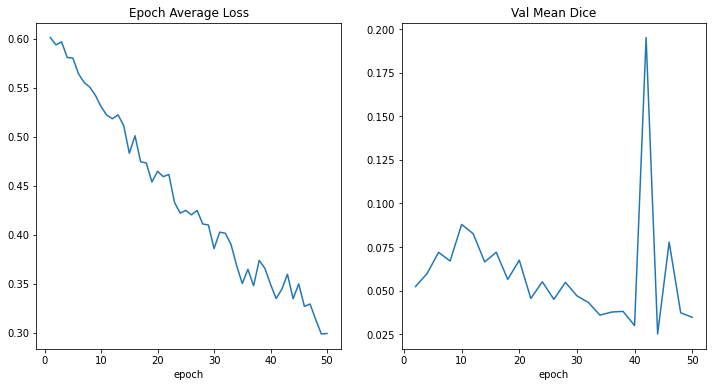

In [13]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

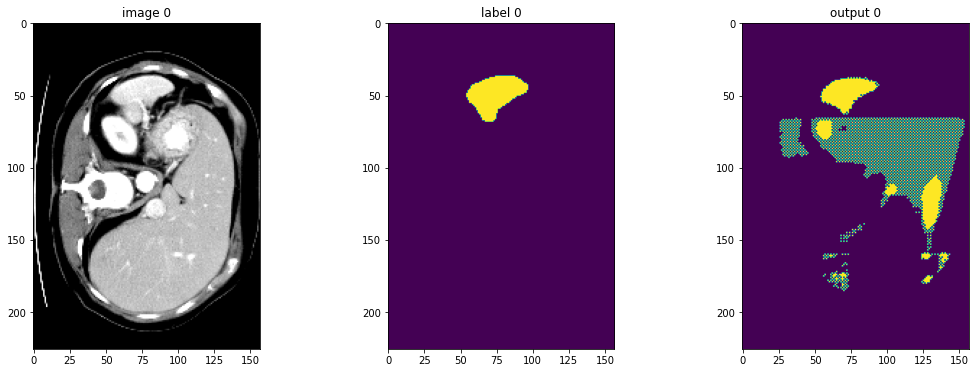

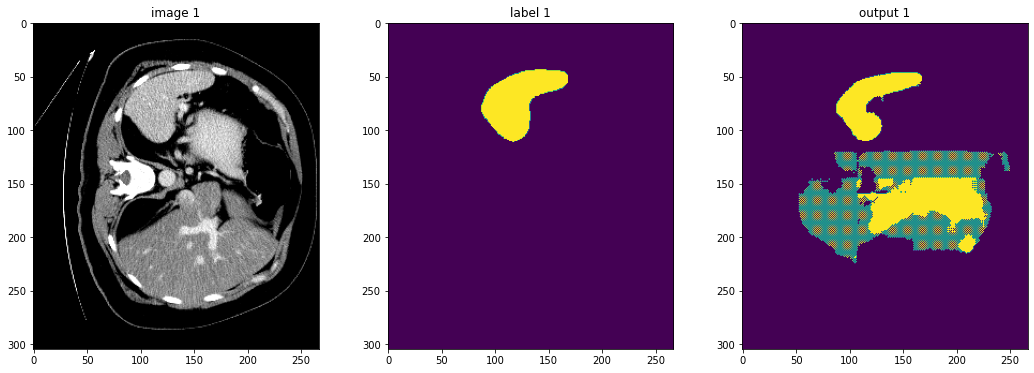

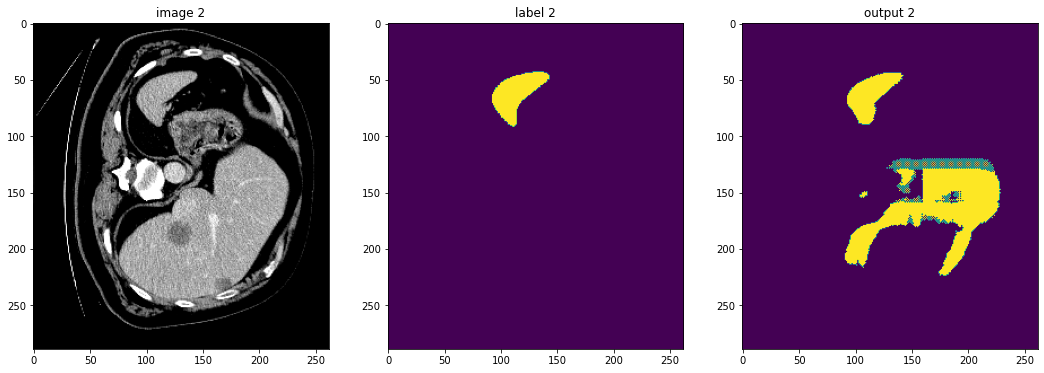

In [14]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break